In [54]:
#importation des bibiotheque necessaire
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
np.set_printoptions(precision=2, linewidth=80)
from nltk import FreqDist

# Gensim
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
import re
#from bs4 import BeautifulSoup
import unicodedata

from spacy.lang.fr.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import fr_core_news_md #import spacy french stemmer
from sklearn.decomposition import NMF

In [41]:
#Tokenization
def tokenize_text(corpus):
    tokensCorpus=[]
    for doc in corpus:
        doc_tokens = word_tokenize(doc)
        tokensCorpus.append(doc_tokens)
    return tokensCorpus

# removing stopwords
def remove_stopwords(corpus):
    filtered_corpus=[]
    for tokens in corpus:
        #french_sw = stopwords.words('french') 
        french_sw=list(STOP_WORDS) #get french stopwords
        filtered_tokens = [token for token in tokens.split() if token not in french_sw and len(token)>2]
        filtred_text=' '.join(filtered_tokens) #reforme le text du documents separé par espace
        filtered_corpus.append(filtred_text)
    return filtered_corpus

def make_bigrams(texts):
    list_bigrams=[]
    for doc in texts :
        # Tokenize
        tokens = word_tokenize(doc)
        # bigrams 
        bigrams = [w for w in ngrams(tokens,n=2)]
        list_bigrams.append(bigrams)
    return list_bigrams

def unique_bigrams(texts):
    list_bigrams = make_bigrams(texts)
    list_unique_bigrams=[]
    for list_bigram in list_bigrams :
        list_unique_bigrams.append(list(set(list_bigram)))
    return list_unique_bigrams

def count_unique_bigrams(texts):
    list_unique_bigrams = unique_bigrams(texts)
    list_count_unique_bigrams = []
    for list_unique_bigram in list_unique_bigrams :
        list_count_unique_bigrams.append(len(list_unique_bigram))
    return list_count_unique_bigrams

def tf_function(bigrams,bigram):
    n=len(bigrams) #nombre de bigrams uniques dans le texte
    m= bigrams.count(bigram) # nombre d'occurence du bigram en parametre dans la liste de bigrams
    return  m/(n+1)

def idf_function(whole_bigram,bigram):
    list_idf = []
    s = 0
    for bigrams in whole_bigram:  
        if bigram in bigrams:
            s += 1
    return np.log((len(whole_bigram)/(s+1))+1)

def tf_idf_function(whole_bigram,bigrams,bigram):
    return tf_function(bigrams,bigram) * idf_function(whole_bigram,bigram)

#output French accents correctly
def convert_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore')

#convertisse les documents en minuscule
def lower_text(corpus):
    LowerCorpus=[]
    for doc in corpus:
        lowerDoc=str(doc).lower() #convertissent le texte en minuscules
        lowerDoc=convert_accents(lowerDoc).decode("utf-8") #supprimes les accents
        LowerCorpus.append(lowerDoc)
    return LowerCorpus

#supprimes caracteres speciaux
def remove_characters(corpus,keep_apostrophes=True):
    filtered_corpus=[]
    for doc in corpus:
        doc = doc.strip()
        if keep_apostrophes:
            doc =re.sub('(https|http)\S*\s?', '',doc) #supprimes les urls
            doc =re.sub("l\'","",doc)
            doc =re.sub("d\'","",doc)
            PATTERN = r'[?|$|&|*|-|!|%|@|(|)|~|\d]'
            filtered_doc = re.sub(PATTERN, r'', doc)
            filtered_corpus.append(filtered_doc)
        else:
            PATTERN = r'[^a-zA-Z ]'
            #supprimes les urls
            doc =re.sub('(https|http)\S*\s?', '',doc) #supprimes les urls
            filtered_doc = re.sub(PATTERN, r'', doc)
        
            filtered_corpus.append(filtered_doc)
    return filtered_corpus

#recuperer les mots qui apparaissent dans plusieurs documents
def get_mostCommonWords(corpus,max_freq=100):
    vocabulaire=dict() #dictionnaire qui va contenir le nombre d'occurence des mots dans les documents
    for doc in corpus:
        for word in set(doc.split()): #recupere les mots unique de chaque documents
            if word in vocabulaire:
                vocabulaire[word]+=1
            else:
                vocabulaire[word]=1
    
    #recupere les dont le nombre d'occurences dans les documents > max_freq
    mostCommonsWord=[word for word,value in vocabulaire.items() if value>max_freq ]
        
    return mostCommonsWord

#lemmatisation
def lemm_tokens(corpus):
    
    nlp = fr_core_news_md.load() #initialisation du model "fr_core_news_md" de spacy
    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    corpus_lemms=[]
    
    for document in corpus:
        doc = nlp(document)
        lemms=[token.lemma_ for token in doc if token.pos_ in allowed_postags] #recupere les lemms des tokens
        text=' '.join(lemms) #reforme le text du documents separé par espace
        corpus_lemms.append(text)
            
    return corpus_lemms
#fonction qui supprimes les documents vides ou tres courte
def remove_shortDocument(corpus,min_length=3):
    filtred_corpus=[]
    idx_doc=[]
    for idx,doc in enumerate(corpus):
        
        if len(doc.split())>min_length:
            filtred_corpus.append(doc)
            idx_doc.append(idx)
        
    
    return filtred_corpus,idx_doc

# extracts topics with their terms and weights
# format is Topic N: [(term1, weight1), ..., (termn, weightn)]        
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    
    #trie les indices des mots de chaque topics selon la poids du mots dans le topics
    sorted_indices = np.array([list(row[::-1]) for row in np.argsort(np.abs(weights))])
    
    #trie les poids des mots de chaques topics,en recuperant les poids des indices deja triée
    sorted_weights = np.array([list(wt[index]) for wt, index in zip(weights,sorted_indices)])
    
    #recupres les mots selon leurs indices deja triée
    sorted_terms = np.array([list(feature_names[row]) for row in sorted_indices])
    
    #concatene chaque mots et sa poids sous formes de tuple (mot,poids)
    topics = [np.vstack((terms.T, term_weights.T)).T for terms, term_weights in zip(sorted_terms, sorted_weights)]     
    
    return topics

def compute_coherence_values(tfidf_train_features,feature_names,corpus,data_lemmatized,id2word,max_term=20,limit=50, start=5, step=5):
    """
    Calcul la coherence UMass pour different nombre de topic
    
    Parameters:
    ----------
    tfidf_train_features : features tf-idf qu'on va utiliser pour entrainer chaque model
    feature_names : ensemble des mots contenue dans la matrice tf-idf
    corpus: corpus de base qui contients les documents sous forme de texte
    max_term: nombre maximal de mots qu'on va prendre pour calculé la coherence de chaque topic
    data_lemmatized: corpus sous forme de tokens
    id2word:vocabulaire du corpus au format de gensim
    max_term:le nombre de termes qu'on va prendre dans chaque topic pour calculer la Coherence
    limit : Nombre maximal de topics qu'on va tester

    Returns:
    -------
    best_model : le model qui contient le plus grande coherence
    coherence_values : Valeurs des Cohérences correspondant au modèle avec le nombre respectif de sujets
    """
    
    
    model_list = [] #listes qui va contenir les modeles tester
    coherence_values = [] #liste qui contenir les coherences de chaque models
    # Term Document Frequency
    
    common_corpus = [id2word.doc2bow(text) for text in data_lemmatized] #recupere la matrice bog of word du corpus sous le format de gensim

    
    #print(coherence)
    for num_topics in range(start, limit, step):
        
        model=NMF(n_components=num_topics,random_state=42) #model MNF
        model.fit(tfidf_train_features)
        weights = model.components_ #recupere les poids
        
        model_list.append(model) #ajoute le model la liste des models utilisé
        
        
        topics=get_topics_terms_weights(weights,feature_names)
        
        topic_terms=getTopicTerms(topics)#recupere les mot des de chaque topics
        
        topic_terms=[topics[:max_term] for topics in topic_terms] #recupere les  "max_term" termes avec les plus grandes poids
        
        #calcule du Coherence UMass
        cm = CoherenceModel(topics=topic_terms,corpus=common_corpus, dictionary=id2word, coherence='u_mass')
        coherence = cm.get_coherence()
        coherence_values.append(coherence)
    
    idx_max=np.array(coherence_values).argmax() #recupere l'indice du model qui possede le plus grands coherence
    best_model=model_list[idx_max] #recupere le meilleur models
    

    return best_model,coherence_values

def getTopicTerms(pos_topics):
    """
    Fonction qui retourne l'ensemble des mots qui compose chaque topics
    ----Input----
    pos_topics: ensemble des topics qui contients les mots et leurs poids
    ---output---
    topic_terms : ensemble des mots des topics
    
    """
    topic_terms=[]
    for topic in pos_topics:
        #topic=topic[:max_term] #recupere les "max_term" premiere mots et leurs poids
        terms=[]
        for doc in topic:
            terms.append(doc[0]) #recupere justes les mots sans les poids
        
        topic_terms.append(terms) #ajoute l'ensemble des mots
    
    return topic_terms

In [3]:
def preprocessing(corpus):
    
    corpus=remove_characters(corpus)
    corpus=lower_text(corpus)
    corpus=remove_stopwords(corpus)
    corpus=lemm_tokens(corpus)
    
    return corpus

In [11]:
df1 = pd.read_csv(r"..\Scraping\Raw_data\1.csv", sep=",", parse_dates=['date'])
df2 = pd.read_csv(r"..\Scraping\Raw_data\2.csv", sep=",", parse_dates=['date'])
df3 = pd.read_csv(r"..\Scraping\Raw_data\3.csv", sep=",", parse_dates=['date'])
dataset = pd.concat([df1, df2, df3])
dataset.head()

,text,date,link
0,La Confédération générale des entreprises du M...,2022-06-09,https://www.challenge.ma/maroc-emirats-arabes-...
1,"Selon Bank Al-Maghrib, l’encours du crédit ban...",2022-06-03,https://www.challenge.ma/banques-les-prets-acc...
2,"Dans le cadre des Rencontres du Livre Blanc, l...",2022-06-03,https://www.challenge.ma/la-cgem-met-le-cap-su...
3,Pour la première fois depuis la création des I...,2022-06-02,https://www.challenge.ma/le-maroc-pays-africai...
4,Les levées des capitaux se sont établies à plu...,2022-06-01,https://www.challenge.ma/marche-des-capitaux-l...


In [12]:
dataset['period']=dataset['date'].dt.to_period('M')
dataset.sort_values(by="date" ,inplace=True)

In [23]:
corpus = dataset.text.values.tolist()
print("Taille du corpus = "+str(len(corpus))+" Documents")

Taille du corpus = 74 Documents


In [26]:
corpus = preprocessing(corpus)

In [27]:
corpuses_NMF = []
l_periods=list(set(dataset.period.values))
l_periods.sort()
for i in range(len(l_periods)-1) :
    indice1=dataset.period.values.tolist().index(l_periods[i])
    indice2=dataset.period.values.tolist().index(l_periods[i+1])
    liste = []
    for j in range(indice1,indice2,1):
        liste.append(corpus[j]) 
    corpuses_NMF.append(liste)

dernier_indice=dataset.period.values.tolist().index(l_periods[1])
derniere_corpus = [] 
for j in range(dernier_indice,len(dataset),1):
    derniere_corpus.append(corpus[j]) 
corpuses_NMF.append(derniere_corpus)

## TF-IDF

In [8]:
# build TFIDF features on train reviews with a specifique vocabulary
corpus_lemmatized=tokenize_text(corpus) 
id2word = corpora.Dictionary(corpus_lemmatized)
vocabulaire=id2word.token2id #get vocabulary dict where keys are terms and values are indices in the feature matrix

tfidf = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0,sublinear_tf=True,lowercase=True,ngram_range=(1,2),vocabulary=vocabulaire)
tfidf_train_features = tfidf.fit_transform(corpus)

c:\Users\hp\PycharmProjects\pythonProject1\venv\lib\site-packages\sklearn\feature_extraction\text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [9]:
feature_names = tfidf.get_feature_names()

c:\Users\hp\PycharmProjects\pythonProject1\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [10]:
feature_names = tfidf.get_feature_names()
tfidf_train_features_array = tfidf_train_features.toarray()
tf_idf_frame = pd.DataFrame(tfidf_train_features_array,columns=feature_names)

## bigrams processing

In [59]:
list_bigrams = make_bigrams(corpus)

In [63]:
def data_frame_bigrams(list_bigrams):
    """Create DataFrame with list of bigrams to be used in association rule learning with R"""
    
    # Create a list of column names
    columns_bigrams_df = []
    for bigrams in list_bigrams :
        for bigram in bigrams :
            if bigram not in columns_bigrams_df :
                columns_bigrams_df.append(bigram)
    
    # Create dataframe with bigrams
    data_frame_bigrams = []
    for bigrams in list_bigrams :
        l_bigrams=[0 for i in range(len(columns_bigrams_df))]
        for bigram in bigrams :
            l_bigrams[columns_bigrams_df.index(bigram)]=1
        data_frame_bigrams.append(l_bigrams)
    
    df = pd.DataFrame(data_frame_bigrams,columns=columns_bigrams_df)

    return df

def  data_frame_tf_idf_bigrams(list_bigrams):
    """Create TF-IDF DataFrame with list of bigrams that contains the columns TF and IDF of each bigram"""
    
    # Create a list of column names
    
    unique_bigrams_columns = []
    intermediate = []
    list_tf_idf_bigrams = []
    for bigrams in list_bigrams :
        for bigram in bigrams :
            if bigram not in unique_bigrams_columns :
                unique_bigrams_columns.append(bigram)
                intermediate.extend([bigram,bigram])
                list_tf_idf_bigrams.extend(["TF","IDF"])

    # list of column names ==> 2 indexes : bigram and TF/IDF
    columns_bigrams_df = [intermediate,list_tf_idf_bigrams] 

    index=["C1","C2","C3","C4","C5","C6","C7","C8","C9","C10","C11","C12","C13","C14",
    "C15","C16","C17","C18","C19","C20","C21","C22","C23","C24","C25","C26","C27","C28","C29","C30","C31","C32",
    "C33","C34","C35","C36","C37","C38","C39","C40","C41","C42","C43","C44","C45","C46","C47","C48","C49","C50",
    "C51","C52","C53","C54","C55","C56","C57","C58","C59","C60","C61","C62","C63","C64","C65","C66","C67","C68","C69",
    "C70","C71","C72","C73","C74"]
    
    # Create tf-idf dataframe with bigrams
    data_frame_bigrams = []

    for bigrams in list_bigrams :
        l_bigrams=[]
        for bigram in unique_bigrams_columns :
            l_bigrams.extend([tf_function(bigrams,bigram),idf_function(list_bigrams,bigram)])
        data_frame_bigrams.append(l_bigrams)
    

    df = pd.DataFrame(data_frame_bigrams,columns=columns_bigrams_df,index=index)

    return df    

In [61]:
df_bigrams = data_frame_bigrams(list_bigrams)

In [64]:
tf_idf_bigrams = data_frame_tf_idf_bigrams(list_bigrams)

ValueError: 39266 columns passed, passed data had 78532 columns

In [44]:
################ define process function ########################## 

def process_corpus(corpus,indice):
    """retourne une liste output"""
    ########### former la matrice tf-idf #############################
    corpus_lemmatized=tokenize_text(corpus) 
    id2word = corpora.Dictionary(corpus_lemmatized)
    vocabulaire=id2word.token2id 
    tfidf = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0,sublinear_tf=True,
                        lowercase=True,ngram_range=(1,2),vocabulary=vocabulaire)
    tfidf_train_features = tfidf.fit_transform(corpus)
    feature_names = tfidf.get_feature_names()
    ################# Topic Modelling : NMF ############################################
    total_topics = 10
    pos_nmf=NMF(n_components=total_topics,random_state=42,l1_ratio=0.2,max_iter=200)
    pos_nmf.fit(tfidf_train_features) 
    pos_weights = pos_nmf.components_
    pos_topics = get_topics_terms_weights(pos_weights, feature_names)
    topic_terms=getTopicTerms(pos_topics)
    topic_terms=[topics[:20] for topics in topic_terms] 
    common_corpus = [id2word.doc2bow(text) for text in corpus_lemmatized] 
    ####### choix du meilleur model ###################################
    cm = CoherenceModel(topics=topic_terms,corpus=common_corpus, dictionary=id2word, 
               coherence='u_mass')
    coherence = cm.get_coherence()
    best_model,coherence_values=compute_coherence_values(tfidf_train_features,
    feature_names,corpus,corpus_lemmatized,id2word,max_term=20,limit=50)
    ######## résultat du modèle optimal ##############################
    total_topics=best_model.n_components 
    weights = best_model.components_ 
    topics = get_topics_terms_weights(weights,feature_names)
    ##### Data_For_Plot ########################################################
    period = l_periods[indice]
    dataset_modified = dataset.loc[dataset.period == period , :]
    dates=pd.to_datetime(dataset_modified.loc[:,"date"].values)
    doc_topic_dist = best_model.transform(tfidf_train_features) 
    labels=getTopicTerms(topics)
    labels=[",".join(topic_term[:5]) for topic_term in labels] 
    df=pd.DataFrame({"text":corpus,"Date":dates,"doc_num":np.arange(len(corpus))})
    stories=df.groupby("doc_num")["text","Date"].min().reset_index() 
    story_topics_for_plot=pd.DataFrame(dict(doc_num=np.arange(doc_topic_dist.shape[0])))
    for idx in range(len(labels)):
        story_topics_for_plot[labels[idx]] = doc_topic_dist[:, idx]
    trends = stories.merge(story_topics_for_plot, on='doc_num')
    mass = lambda x: ((x) * 1.0).sum() / x.shape[0]  
    window = 10
    trend_indice = min(len(labels),5)
    aggs = {labels[i]: mass for i in range(trend_indice) }
    data_for_plot=trends.groupby(trends['Date'].dt.date).agg(aggs).rolling(window).mean()

    ######### output de chaque corpus ###############################
    output=[story_topics_for_plot,data_for_plot]

    return output

In [56]:
test = process_corpus(corpuses_NMF[1],1)

c:\Users\Original Shop\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
c:\Users\Original Shop\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
c:\Users\Original Shop\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
c:\Users\Original Shop\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceW

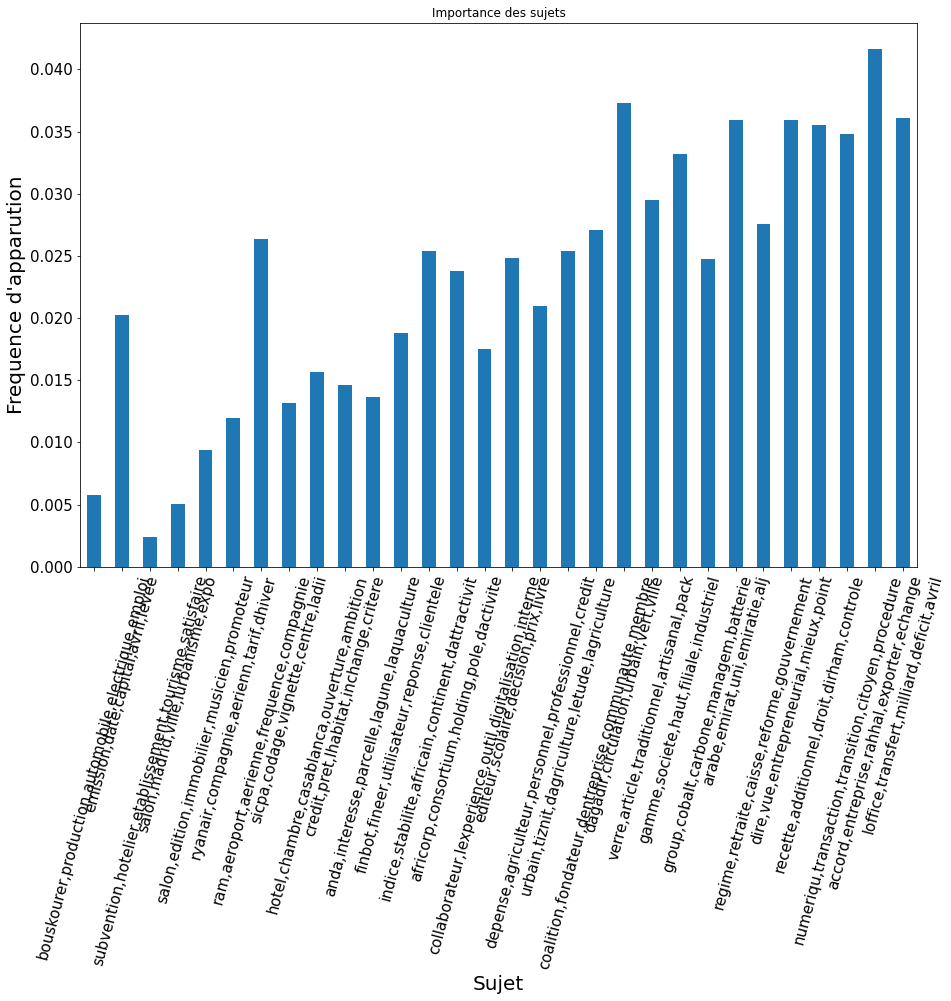

In [57]:
test[0].drop(["doc_num"],axis=1).mean(axis=0).plot(kind='bar', title ="Importance des sujets",
                                                        figsize=(15,10), fontsize=15)
plt.xlabel("Sujet", fontsize=20)
plt.xticks(rotation=75)
plt.ylabel("Frequence d'apparution", fontsize=20)
plt.show()

<AxesSubplot:xlabel='Date'>

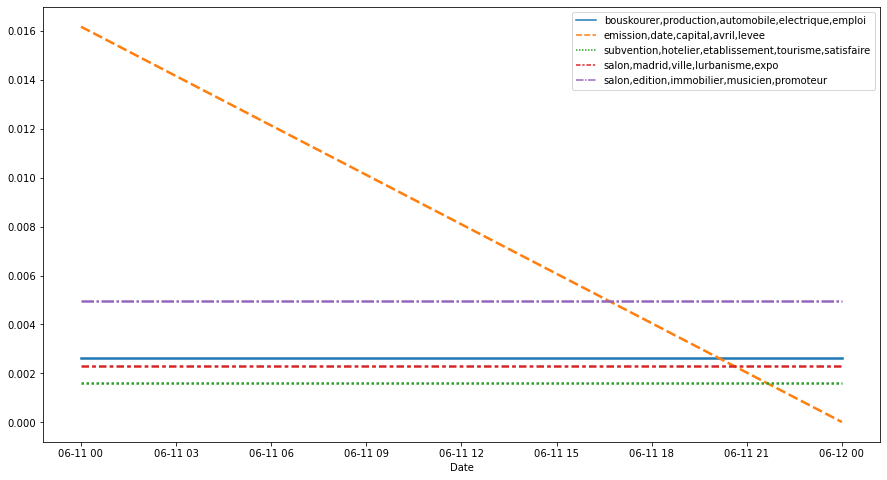

In [58]:
plt.figure(figsize=(15,8))
sns.lineplot(data=test[1], palette="tab10", linewidth=2.5)

In [66]:
outputs =[]
for i in range(len(corpuses_NMF)): 
    outputs.append(process_corpus(corpuses_NMF[i],i))

c:\Users\Original Shop\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
c:\Users\Original Shop\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
c:\Users\Original Shop\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
c:\Users\Original Shop\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning